In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from diffusion_equation import compute_solution
from time import time
from tqdm import trange
import pandas as pd
from sklearn.metrics import r2_score

# Getting data from simulator

In [15]:
def flat_the_gradient_from_loss(model, loss):
    model.zero_grad()
    loss.backward(retain_graph=True)
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.detach().cpu().numpy().reshape(-1))
    grad_flat = np.concatenate(grads)
    return grad_flat

def orthogonalize(v1, v2):
    dot = np.dot(v1, v2)
    proj = dot / (np.dot(v1, v1) + 1e-6) * v1
    return v2 - proj

def compute_weights_grad_orthogonal_autograd(model, loss_ic, loss_pde, loss_data, kappa=5.0, eps=1e-6):
    grad_ic   = flat_the_gradient_from_loss(model, loss_ic)
    grad_pde  = flat_the_gradient_from_loss(model, loss_pde)
    grad_data = flat_the_gradient_from_loss(model, loss_data)

    grad_pde_orth = orthogonalize(grad_ic, grad_pde)
    grad_data_orth = orthogonalize(grad_ic, grad_data)
    grad_data_orth = orthogonalize(grad_pde_orth, grad_data_orth)

    lv_ic = loss_ic.detach().cpu().numpy()
    lv_pde = loss_pde.detach().cpu().numpy()
    lv_data = loss_data.detach().cpu().numpy()

    w_ic = 1.0
    w_pde = np.exp(-kappa * lv_ic) * np.linalg.norm(grad_pde_orth)
    w_data = np.exp(-kappa * max(lv_ic, lv_pde)) * np.linalg.norm(grad_data_orth)
    w_sum = w_ic + w_pde + w_data + eps
    w_ic /= w_sum
    w_pde /= w_sum
    w_data /= w_sum


    # model.zero_grad()

    return w_ic, w_pde, w_data

In [2]:
# configuration of simulator
# and parametrs of reservouir
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

niter = 5000
t_final = 3.0
dt = t_final / niter

In [3]:
nx0, nx1

(64, 64)

# Read from file

In [5]:
n_points = 500
sim_r = np.random.randint(0, 5000, n_points)

# 5000
sim_data = np.loadtxt("data_5k_200225/sim_5000.txt", dtype=np.float32)[sim_r]
x_list = np.loadtxt("data_5k_200225/x_5000.txt", dtype=np.float32)[sim_r]
y_list = np.loadtxt("data_5k_200225/y_5000.txt", dtype=np.float32)[sim_r]
t_list = np.loadtxt("data_5k_200225/t_5000.txt", dtype=np.float32)[sim_r]
# sim_data, x_list, y_list, t_list

In [9]:
simulation_data = torch.tensor(sim_data).requires_grad_(True)

x = torch.tensor(x_list * dx0).requires_grad_(True)
y = torch.tensor(y_list * dx1).requires_grad_(True)
t = torch.tensor(t_list * dt).requires_grad_(True)

points = torch.stack((t, x, y), -1).requires_grad_(True)
# points, simulation_data

# Boundary points

In [10]:
pres0_x1_points = torch.stack((t, torch.zeros_like(x), y), -1).requires_grad_(True)
pres1_x1_points = torch.stack((t, torch.ones_like(x), y), -1).requires_grad_(True)
swat0_x1_points = torch.stack((torch.zeros_like(t), x, y), -1).requires_grad_(True)
soil0_x1_points = torch.stack((torch.zeros_like(t), x, y), -1).requires_grad_(True)
u0_x2_points = torch.stack((t, x, torch.zeros_like(y)), -1).requires_grad_(True)
u1_x2_points = torch.stack((t, x, torch.ones_like(y)), -1).requires_grad_(True)

# Model configuration

In [16]:
# class ModifiedPINN(nn.Module):
#     """
#     Modified MLP architecture based on Wang et al. with U-Net style connections.
#     Particularly effective for capturing sharp gradients in pressure/saturation.
    
#     Key improvements:
#     - Modified MLP with U and V paths (proven effective for PINNs)
#     - Skip connections for gradient flow
#     - Separate branches for different physics (pressure vs saturation)
#     - Adaptive activation functions
#     """
    
#     def __init__(self, input_dim=3, hidden_dim=128, num_layers=6, output_dim=7):
#         super(ModifiedPINN, self).__init__()
        
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
        
#         # Modified MLP: Two parallel input branches (U and V paths)
#         self.U = nn.Linear(input_dim, hidden_dim)
#         self.V = nn.Linear(input_dim, hidden_dim)
        
#         # Hidden layers with residual connections
#         self.hidden_layers = nn.ModuleList()
#         for i in range(num_layers - 1):
#             self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        
#         # Output layer
#         self.output_layer = nn.Linear(hidden_dim, output_dim)
        
#         # Learnable scaling parameters for outputs
#         self.pressure_scale = nn.Parameter(torch.ones(1))
#         self.saturation_scale = nn.Parameter(torch.ones(2))
#         self.velocity_scale = nn.Parameter(torch.ones(4))
        
#         self._initialize_weights()
    
#     def _initialize_weights(self):
#         """Xavier initialization for better gradient flow."""
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight, gain=1.0)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)
    
#     def forward(self, x):
#         """
#         Forward pass with modified MLP architecture.
        
#         Args:
#             x: Input [batch, 7] -> (t, x, y, pwat, poil, kwat, koil)
        
#         Returns:
#             out: [batch, 7] -> (pres, soil, swat, uoil_x, uoil_y, uwat_x, uwat_y)
#         """
#         # Modified MLP: Two parallel branches
#         U = torch.tanh(self.U(x))
#         V = torch.tanh(self.V(x))
        
#         # Element-wise multiplication (key feature of modified MLP)
#         h = U * V
        
#         # Pass through hidden layers with residual connections
#         for i, layer in enumerate(self.hidden_layers):
#             h_new = torch.tanh(layer(h))
#             # Residual connection every 2 layers
#             if i % 2 == 1 and i > 0:
#                 h = h + h_new  # Skip connection
#             else:
#                 h = h_new
        
#         # Output layer
#         out = self.output_layer(h)
        
#         # Split outputs
#         pressure = out[:, 0:1]
#         saturation_oil = out[:, 1:2]
#         saturation_wat = out[:, 2:3]
#         velocities = out[:, 3:7]
        
#         # Apply constraints with learnable scales
#         # Pressure: softplus for positivity
#         pressure = F.softplus(pressure * self.pressure_scale, beta=1, threshold=20)
        
#         # Saturations: sigmoid to enforce [0, 1] bounds
#         saturation_oil = torch.sigmoid(saturation_oil * self.saturation_scale[0])
#         saturation_wat = torch.sigmoid(saturation_wat * self.saturation_scale[1])
        
#         # Enforce saturation constraint: S_o + S_w = 1
#         # Normalize to ensure sum equals 1
#         sat_sum = saturation_oil + saturation_wat + 1e-8
#         saturation_oil = saturation_oil / sat_sum
#         saturation_wat = saturation_wat / sat_sum
        
#         # Velocities: can be positive or negative, use tanh scaled
#         velocities = torch.tanh(velocities) * self.velocity_scale
        
#         return torch.cat([pressure, saturation_oil, saturation_wat, velocities], dim=1)

In [39]:
# define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 3, hidden_layer = 32, number_layers = 8, output_layer = 7):
        super().__init__()
        
        activation2 = nn.Sigmoid
        activation1 = nn.ReLU
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation1()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation1()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        """
        function for updating neural network
        
        return:
            x - vector (pres
                        soil
                        swat
                        uoil_x,  
                        uoil_y,
                        uwat_x,  
                        uwat_y)
        """
        
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        
        return x

# Model training

In [41]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
# neural network returns:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)

# change learning rate if necessary
# optimizer.param_groups[0]['lr'] = 0.0005
perm_vec = torch.tensor(perm[list(x_list.astype(int)), list(y_list.astype(int)), -1])

epochs = 6_000
for cur_epoch in trange(epochs):
    optimizer.zero_grad()
    
    model_res = model(points).requires_grad_(True)
    # presseru bound
    press0 = model(pres0_x1_points)[:, 0].requires_grad_(True)
    press1 = model(pres1_x1_points)[:, 0].requires_grad_(True)
    
    # struation boundary
    soil0 = model(soil0_x1_points)[:, 1].requires_grad_(True)
    swat0 = model(swat0_x1_points)[:, 2].requires_grad_(True)
    
    # velocity boundary
    uwat0_x2 = model(u0_x2_points)[:, 4].requires_grad_(True)
    uwat1_x2 = model(u1_x2_points)[:, 4].requires_grad_(True)
    uoil0_x2 = model(u0_x2_points)[:, 6].requires_grad_(True)
    uoil1_x2 = model(u1_x2_points)[:, 6].requires_grad_(True)
    
    one_vector = torch.ones_like(model_res[:, 0])
    zeros_vector = torch.zeros_like(model_res[:, 0])
    
    # functions r(t,x)
    r1 = 0.1 * torch.autograd.grad(model_res[:, 2], t, 
                                   one_vector, 
                                   create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 5], x, 
                        one_vector, 
                        create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 6], y, 
                        one_vector, 
                        create_graph=True)[0]
    
    
    r2 = 0.1 * torch.autograd.grad(model_res[:, 1], t, 
                                   one_vector, 
                                   create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 3], x, 
                        one_vector, 
                        create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 4], y, 
                        one_vector, 
                        create_graph=True)[0]
    
    
    
    r3_x1 = model_res[:, 5] + perm_vec * model_res[:, 2]**2 * (torch.autograd.grad(model_res[:, 0], 
                                                               x, one_vector, 
                                                               create_graph=True)[0])
    
    r3_x2 = model_res[:, 6] + perm_vec * model_res[:, 2]**2 * (torch.autograd.grad(model_res[:, 0], 
                                                               y, one_vector, 
                                                               create_graph=True)[0])

    r4_x1 = model_res[:, 3] + (1/3) * perm_vec * 0.1 * model_res[:, 2]**4 * (torch.autograd.grad(model_res[:, 0], 
                                                                             x, one_vector, 
                                                                             create_graph=True)[0])
    
    r4_x2 = model_res[:, 4] + (1/3) * perm_vec * 0.1 * model_res[:, 2]**4 * (torch.autograd.grad(model_res[:, 0], 
                                                                             y, one_vector, 
                                                                             create_graph=True)[0])
    
    r5 = model_res[:, 2] + model_res[:, 1] - one_vector
    
    
    # Loss0
    loss0 = torch.mean(r1**2 + r2**2 + r3_x1**2 + r3_x2**2 + 
                       r4_x1**2 + r4_x2**2 + r5**2).requires_grad_(True)
    
    # Loss1
    loss1 = torch.mean((press0 - one_vector)**2 + press1**2 + \
                       (soil0 - one_vector)**2 + swat0**2).requires_grad_(True) 
    # +\
    #                    uwat0_x2**2 + uwat1_x2**2 +\
    #                    uoil0_x2**2 + uoil1_x2**2).requires_grad_(True)

    # x - vector (pres
    #             soil
    #             swat
    #             uoil_x,  
    #             uoil_y,
    #             uwat_x,  
    #             uwat_y)

    # Loss2
    loss2 = torch.mean((model_res[:,0] - simulation_data[:,0])**2 + (model_res[:,2] - simulation_data[:,1])**2 + \
                       (model_res[:,1] - simulation_data[:,2])**2).requires_grad_(True)
    

    # algo for weights adjustment
    # l1 = loss1.clone().detach().requires_grad_(True)
    # l2 = loss2.clone().detach().requires_grad_(True)
    # l0 = loss0.clone().detach().requires_grad_(True)
    # l1.backward(retain_graph=True)
    # l2.backward(retain_graph=True)
    # l0.backward(retain_graph=True)
    # w0 = abs(l0 / (l0 + l1 + l2))
    # w1 = abs(l1 / (l1 + l0 + l2))
    # w2 = abs(l2 / (l1 + l0 + l2))
    
    
    # # losses history
    # loss0_hist.append(loss0.detach().numpy())
    # loss1_hist.append(loss1.detach().numpy())
    # loss2_hist.append(loss2.detach().numpy())
    
    # #weights history
    # w0_hist.append(w0.detach().numpy())
    # w1_hist.append(w1.detach().numpy())
    # w2_hist.append(w2.detach().numpy())
    w_ic, w_pde, w_data = compute_weights_grad_orthogonal_autograd(
        model, loss1, loss0, loss2, kappa=15.0
    )
    
    # Combined loss
    loss = w_pde * loss0 + w_ic * loss1 + w_data * loss2
    
    dist = loss0 + loss1 + loss2
    loss.backward(retain_graph=True)
    optimizer.step()
    if cur_epoch % 5_000 == 0:
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / 10
    if cur_epoch % 250 == 0:
        print(f'epoch: {cur_epoch}\tloss: {float(dist.detach().numpy()), float(loss0.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy())}\t')
#         print(w0, '\t', w1, '\t', w2)

  0%|                                                                                                                  | 5/6000 [00:00<04:37, 21.63it/s]

epoch: 0	loss: (4.178786372824616, 1.164923047705598, 1.8418998718261719, 1.1719634532928467)	


  4%|████▊                                                                                                           | 257/6000 [00:06<02:21, 40.47it/s]

epoch: 250	loss: (2.1534366721112894, 0.35279406251503714, 1.1856169700622559, 0.6150256395339966)	


  8%|█████████▍                                                                                                      | 504/6000 [00:13<02:13, 41.02it/s]

epoch: 500	loss: (0.6526017372876259, 0.007364336159810742, 0.5117075443267822, 0.13352985680103302)	


 13%|██████████████                                                                                                  | 755/6000 [00:20<02:07, 41.11it/s]

epoch: 750	loss: (0.42514560615661257, 0.03249890601279846, 0.2726489305496216, 0.1199977695941925)	


 17%|██████████████████▌                                                                                            | 1005/6000 [00:25<01:57, 42.60it/s]

epoch: 1000	loss: (0.1703475104579579, 0.04159797597023359, 0.03791676461696625, 0.09083276987075806)	


 21%|███████████████████████▏                                                                                       | 1255/6000 [00:32<02:01, 39.18it/s]

epoch: 1250	loss: (0.02600773004186975, 0.0021655247483931676, 0.003600980155169964, 0.020241225138306618)	


 25%|███████████████████████████▊                                                                                   | 1506/6000 [00:37<01:45, 42.65it/s]

epoch: 1500	loss: (0.018469219654352526, 0.0008173061995963865, 0.0023454937618225813, 0.01530641969293356)	


 29%|████████████████████████████████▍                                                                              | 1756/6000 [00:43<01:41, 41.79it/s]

epoch: 1750	loss: (0.014394073928216303, 0.0006117093791010024, 0.0018364342395216227, 0.011945930309593678)	


 33%|█████████████████████████████████████▏                                                                         | 2008/6000 [00:49<01:40, 39.78it/s]

epoch: 2000	loss: (0.010155988774243898, 0.000785306362416751, 0.0010706015164032578, 0.00830008089542389)	


 38%|█████████████████████████████████████████▊                                                                     | 2258/6000 [00:56<01:30, 41.45it/s]

epoch: 2250	loss: (0.00734731986723473, 0.0007302879339606096, 0.0006187511025927961, 0.005998280830681324)	


 42%|██████████████████████████████████████████████▎                                                                | 2506/6000 [01:02<01:26, 40.34it/s]

epoch: 2500	loss: (0.006089731494096872, 0.0008789591336546661, 0.00041620314004831016, 0.004794569220393896)	


 46%|██████████████████████████████████████████████████▉                                                            | 2756/6000 [01:08<01:21, 39.83it/s]

epoch: 2750	loss: (0.00549185304127592, 0.0011015883837170468, 0.0002781402145046741, 0.004112124443054199)	


 50%|███████████████████████████████████████████████████████▌                                                       | 3005/6000 [01:14<01:16, 39.15it/s]

epoch: 3000	loss: (0.004994162314662261, 0.0010869870311324653, 0.00022593095491174608, 0.0036812443286180496)	


 54%|████████████████████████████████████████████████████████████▏                                                  | 3256/6000 [01:20<01:08, 40.29it/s]

epoch: 3250	loss: (0.004612589157698177, 0.0010577034018230292, 0.000190102044143714, 0.003364783711731434)	


 58%|████████████████████████████████████████████████████████████████▉                                              | 3507/6000 [01:26<00:58, 42.77it/s]

epoch: 3500	loss: (0.004278986995248292, 0.0010320027107607393, 0.00017978933465201408, 0.003067194949835539)	


 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3758/6000 [01:32<00:52, 42.36it/s]

epoch: 3750	loss: (0.004027613123273795, 0.0009970182047461544, 0.00016822225006762892, 0.0028623726684600115)	


 67%|██████████████████████████████████████████████████████████████████████████                                     | 4006/6000 [01:38<00:47, 41.63it/s]

epoch: 4000	loss: (0.003742647958061197, 0.0009295918176216122, 0.00016229788889177144, 0.0026507582515478134)	


 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 4255/6000 [01:44<00:41, 41.79it/s]

epoch: 4250	loss: (0.003495270381578758, 0.00090912337579257, 0.00015895879187155515, 0.002427188213914633)	


 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4507/6000 [01:50<00:37, 40.27it/s]

epoch: 4500	loss: (0.0032866100081789702, 0.000914695541685207, 0.00016390370728913695, 0.002208010759204626)	


 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4755/6000 [01:57<00:30, 40.81it/s]

epoch: 4750	loss: (0.003056666513501674, 0.0008631357976161019, 0.00016439745377283543, 0.0020291332621127367)	


 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 5007/6000 [02:03<00:25, 38.35it/s]

epoch: 5000	loss: (0.0028701487332048726, 0.0009156582978951644, 0.00016569020226597786, 0.0017888002330437303)	


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 5258/6000 [02:09<00:18, 39.25it/s]

epoch: 5250	loss: (0.0028426107851227205, 0.000915983644048443, 0.00016604004485998303, 0.0017605870962142944)	


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5505/6000 [02:15<00:12, 40.78it/s]

epoch: 5500	loss: (0.0028105432849082268, 0.0009089525102575414, 0.00016620200767647475, 0.0017353887669742107)	


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5755/6000 [02:21<00:06, 37.06it/s]

epoch: 5750	loss: (0.002769175840813638, 0.0008998917586095346, 0.0001677144318819046, 0.0017015696503221989)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [02:28<00:00, 40.49it/s]


In [43]:
optimizer.param_groups[0]['lr']

1e-05

In [44]:
dist

tensor(0.0027, dtype=torch.float64, grad_fn=<AddBackward0>)

In [45]:
# def main(model):
#     pwat = 2.0
#     poil = 4.0
#     vr = 0.3
#     kwat = 1.0
#     koil = 0.3

#     # pwat = 1.0
#     # poil = 1.0
#     # vr = 1.0
#     # kwat = 1.0
#     # koil = 1.0
#     pmin = 0.0
#     pmax = 1.0
#     nx0 = 50
#     nx1 = 30
#     nx2 = 1
#     dx0 = 1.0 / nx0
#     dx1 = 1.0 / nx1
#     dx2 = 1.0 / nx2
#     dt = 0.26e-1
#     niter = 100

#     poro = 0.1 + np.zeros((nx0, nx1, nx2))
#     perm = np.ones((nx0, nx1, nx2))
#     swat = np.zeros((nx0, nx1, nx2))
#     soil = np.ones((nx0, nx1, nx2))


#     pres, swat, soil = compute_solution(perm, poro,
#                                         dx0, dx1, dx2, dt * niter, niter,
#                                         pwat, kwat, poil, koil, vr,
#                                         pmin=0.0, pmax=1.0)
    
#     time_for_model = (niter * dt) * torch.ones(1500)
#     x_for_model = dx0 * torch.arange(50)
#     y_for_model = dx1 * torch.arange(30)
#     cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
#     model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
#     model_prediction = model_prediction.detach().numpy()
    
    
    
#     plt.figure()
#     plt.title('Water saturation, simulator')
#     plt.imshow(swat[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_sim.png', facecolor='b')
#     plt.show()
    
#     plt.figure()
#     plt.title('Water saturation, PINN')
#     plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_pinn.png')
#     plt.show()
    
#     plt.figure()
#     plt.title('Pressure, simulator')
#     plt.imshow(pres[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_pressure_sim.png')
#     plt.show()
    

#     plt.figure()
#     plt.title('Pressure, PINN')
#     plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_pressure_pinn.png')
#     plt.show()    
    
    
#     plt.figure()
#     plt.title('Насыщенность воды')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Модель')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='Симулятор')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('swat_scatter.png')
#     plt.show()


#     plt.figure()
#     plt.title('Pressure')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Симулятор')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='Модель')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('pres_scatter.png')
#     plt.show()



#     return 0

In [46]:
# main(model)

In [47]:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)


# 0 - pres, 1 - swat, 2 - soil

In [48]:
def set_big_plot_style(scale: float = 1.2):
    """Global matplotlib style for bigger text/ticks/legend and sharper saved figs."""
    base = 18 * scale
    title = 22 * scale
    label = 20 * scale
    ticks = 16 * scale
    legend = 16 * scale

    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,

        "font.size": base,
        "axes.titlesize": title,
        "axes.labelsize": label,
        "xtick.labelsize": ticks,
        "ytick.labelsize": ticks,
        "legend.fontsize": legend,

        "axes.titlepad": 12,
        "axes.labelpad": 10,
    })

def _add_colorbar_big(im):
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=plt.rcParams.get("ytick.labelsize", 16))
    return cbar

def main_new(model):
    set_big_plot_style(scale=1.3)
    perm = np.load('perm.npy')
    nx0, nx1 = perm.shape
    nx2 = 1
    perm = np.reshape(perm, (nx0, nx1, nx2))
    poro = 0.1 + np.zeros((nx0, nx1, nx2))

    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2

    pwat = 2.0
    poil = 4.0
    vr = 0.3
    kwat = 1.0
    koil = 0.3

    pmin = 0.0
    pmax = 1.0

    dt = 0.26e-1
    niter = 100


    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * torch.ones(64 * 64)
    x_for_model = dx0 * torch.arange(64)
    y_for_model = dx1 * torch.arange(64)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
    model_prediction = model_prediction.detach().numpy()
    
    swat_sim_2d = np.squeeze(swat[:, :, 0, -1])   # (nx0, nx1)
    pres_sim_2d = np.squeeze(pres[:, :, 0, -1])   # (nx0, nx1)

    swat_pinn_2d = np.squeeze(model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, :, 0])
    pres_pinn_2d = np.squeeze(model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, :, 0])

    
    plt.figure()
    plt.title('Water saturation, sim')
    plt.imshow(swat[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('graphs/color_swat_sim.png', bbox_inches="tight")
    plt.show()
    
    plt.figure()
    plt.title('Water saturation, PINN')
    plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('graphs/color_swat_pinn.png', bbox_inches="tight")
    plt.show()
    
    plt.figure()
    plt.title('Pressure, sim')
    plt.imshow(pres[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('graphs/color_pressure_sim.png', bbox_inches="tight")
    plt.show()
    

    plt.figure()
    plt.title('Pressure, PINN')
    plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('graphs/color_pressure_pinn.png', bbox_inches="tight")
    plt.show()    
    
    
    plt.figure()
    plt.title('Water saturation at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.legend()
    plt.savefig('graphs/swat_scatter.png', bbox_inches="tight")
    plt.show()


    plt.figure()
    plt.title('Pressure at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.legend()
    plt.savefig('graphs/pres_scatter.png', bbox_inches="tight")
    plt.show()

    return 0

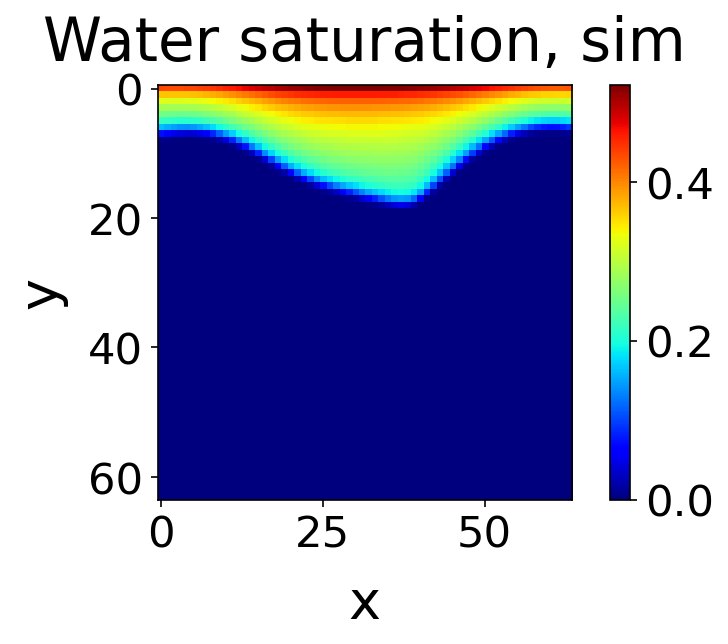

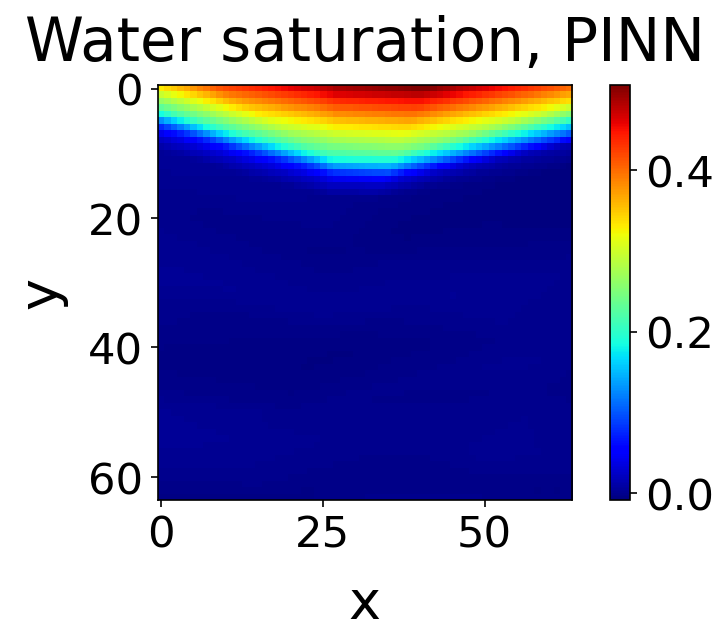

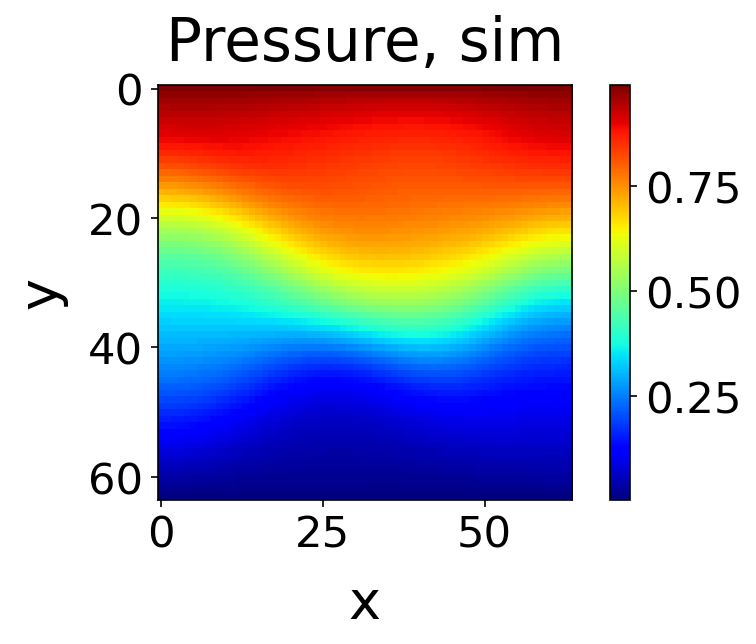

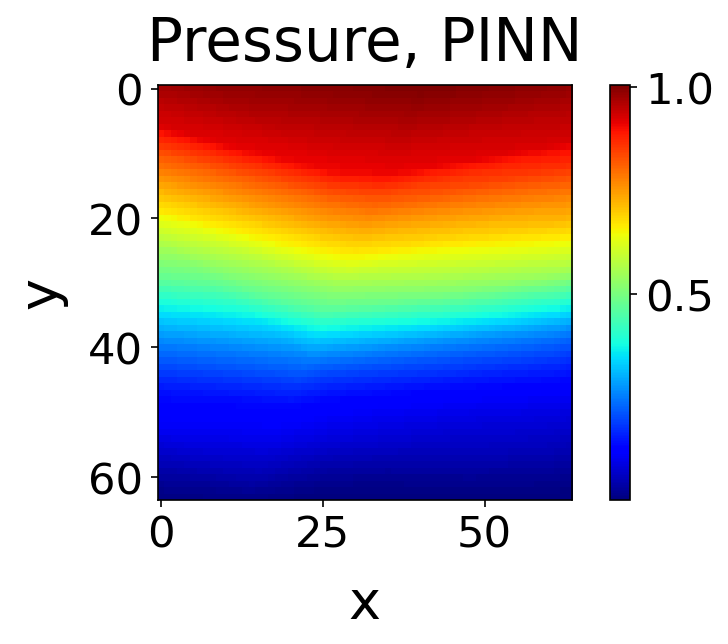

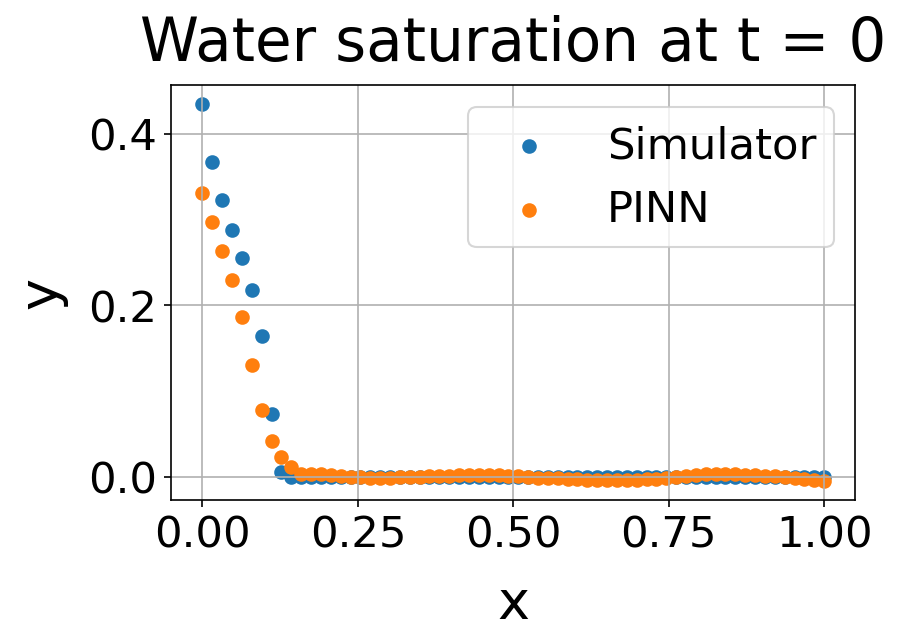

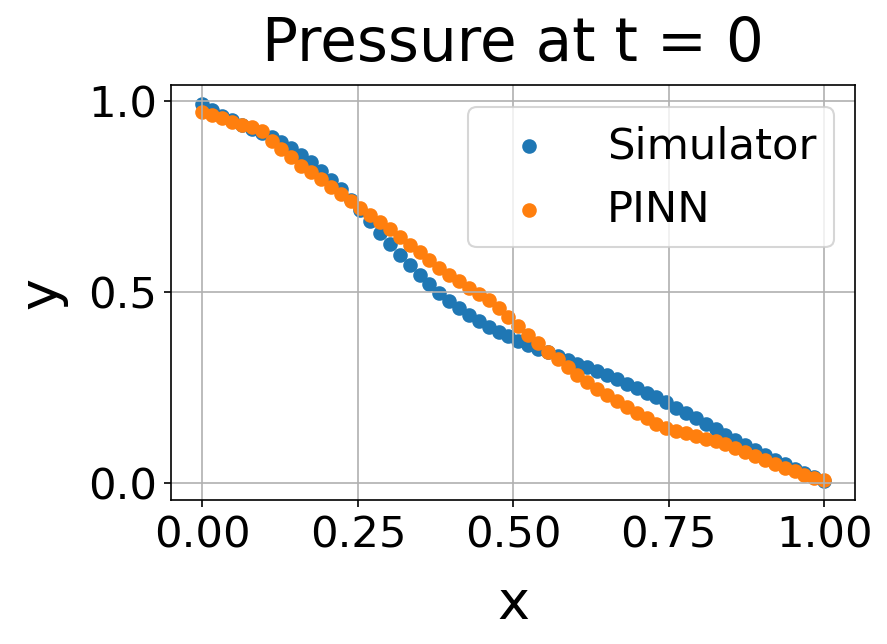

0

In [49]:
main_new(model)

# Metrics

In [50]:
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

dt = 0.26e-1
niter = 100


# swat = np.zeros((nx0, nx1, nx2))
# soil = np.ones((nx0, nx1, nx2))


pres, swat, soil = compute_solution(perm, poro,
                                    dx0, dx1, dx2, dt * niter, niter,
                                    pwat, kwat, poil, koil, vr,
                                    pmin=0.0, pmax=1.0)

time_for_model = (niter * dt) * torch.ones(64 * 64)
x_for_model = dx0 * torch.arange(64)
y_for_model = dx1 * torch.arange(64)
cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
model_prediction = model_prediction.detach().numpy()

In [51]:
metrics = ['MSE', 'MAE', 'R_2', 'RMSE']

satur = [
    np.mean((model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1]) ** 2),
    abs(np.mean(model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1])),
    r2_score(swat[:, 0, 0, -1], model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0]),
    (np.mean((model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1]) ** 2))**0.5
]


press = [
    np.mean((model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1]) ** 2),
    abs(np.mean(model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1])),
    r2_score(pres[:, 0, 0, -1], model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0]),
    (np.mean((model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1]) ** 2))**0.5
]

In [52]:
data = pd.DataFrame({'Metrics': metrics,
                     'Saturation': satur,
                     'Pressure': press})

In [53]:
data

,Metrics,Saturation,Pressure
0,MSE,0.000693,0.001609
1,MAE,0.008567,0.003198
2,R_2,0.924073,0.982405
3,RMSE,0.026322,0.040115
